<a href="https://colab.research.google.com/github/8johan/ML-PROJ/blob/main/unet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
from __future__ import print_function, division
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as fn
import torch.utils.data
import torch
class double_conv(nn.Module):
  def __init__(self ,intc ,outc):
     super().__init__()
     self.conv1 = nn.Conv2d(intc, outc, kernel_size=3,stride=1, padding=0, bias=True)
     self.bn1 = nn.BatchNorm2d(outc)

     self.conv2 = nn.Conv2d(outc, outc, kernel_size=3, stride=1, padding=0, bias=True)
     self.bn2 = nn.BatchNorm2d(outc)

     self.relu = nn.ReLU(inplace=False)
     self.convo=nn.Sequential(
            nn.Conv2d(intc, outc, kernel_size=3, stride=1, padding=0, bias=True),
            #nn.BatchNorm2d(outc),
            #nn.ReLU(inplace=True),
            nn.Conv2d(outc, outc, kernel_size=3, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(outc),
            nn.ReLU(inplace=True))
  def forward(self ,data) :
    x = self.conv1(data)
    x = self.bn1(x)
    x=  self.relu(x)
    x= self.conv2(x)
    x= self.bn2(x)
    x= self.relu(x)
    return x 
   
     
   # x=self.convo(data)
   
    




class upconvo(nn.Module):
  def __init__(self ,intc, outc) :
    super().__init__()
    self.up=nn.ConvTranspose2d(intc, outc, kernel_size=2, stride=2, padding=0)
  def forward(self ,data):
    x=self.up(data)
    return x 


def upconv(data , intc, outc):
  upco=nn.ConvTranspose2d(intc, outc, kernel_size=2, stride=2, padding=0)
  x=upco(data)
  return x 
def crop_copy(img,x):
  croped_size=x.size()[2]
  crop = fn.center_crop(img, output_size=[croped_size])
  y=torch.cat((x, crop), dim=1)
  return y





In [2]:
class countarctive_path(nn.Module):
  def __init__(self ) :
    super().__init__()
    self.convo1=double_conv(3,64)
    self.convo2=double_conv(64,128)
    self.convo3=double_conv(128,256)
    self.convo4=double_conv(256,512)
    self.convo5=double_conv(512,1024)
    
    
    
    self.l=[]
    self.maxpoll=nn.MaxPool2d(kernel_size=2, stride=2)
  def forward(self,data):
    #convo=double_conv(3,64)
    x=self.convo1(data)
    self.l.append(x)
    x=self.maxpoll(x)
   
    print(x.size())
    #convo=double_conv(64,128)
    x=self.convo2(x)
    self.l.append(x)
    x=self.maxpoll(x)
 
    print(x.size())
    #convo=double_conv(128,256)
    x=self.convo3(x)
    self.l.append(x)
    x=self.maxpoll(x)
    
    print(x.size())
    #convo=double_conv(256,512)
    x=self.convo4(x)
   
    self.l.append(x)
    x=self.maxpoll(x)
  
    print(x.size())
    #convo=double_conv(512,1024)
    x=self.convo5(x)
 
  
    
  
    return x

  




In [3]:
class expansive_path(nn.Module):
  def __init__(self):
    super().__init__()
    self.up1=upconvo(1024 ,512)
    self.up2=upconvo(512 ,256)
    self.up3=upconvo(256,128)
    self.up4=upconvo(128 ,64)
    self.conv1=double_conv(1024 ,512)
    self.conv2=double_conv(512 ,256)
    self.conv3=double_conv(256,128)
    self.conv4=double_conv(128 ,64)
    self.conv11=nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0, bias=True)
  
  def forward(self , data ,l):
    x=self.up1(data)
    x=crop_copy(l[3],x)
    x=self.conv1(x )
    x=self.up2(x)
    x=crop_copy(l[2],x)
    x=self.conv2(x )
    x=self.up3(x )
    x=crop_copy(l[1],x)
    x=self.conv3(x )
    x=self.up4(x )
    x=crop_copy(l[0],x)
    x=self.conv4(x )
    conv1=nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0, bias=True)
    x=self.conv11(x)
    print(x.size())
    return x 
   
    




In [4]:
class unet(nn.Module):
  def __init__(self) :
    super().__init__()
    self.countratpath=countarctive_path()
    self.expansivepath=expansive_path()
  def forward(self,data):
    x=self.countratpath(data)
    l=self.countratpath.l
    x=self.expansivepath(x,l)
    
    return x


In [5]:
inputs = torch.randn((2, 3, 572, 572))
modul=unet()
y=modul(inputs)
#modul=unet()
#y=modul(inputs)

torch.Size([2, 64, 284, 284])
torch.Size([2, 128, 140, 140])
torch.Size([2, 256, 68, 68])
torch.Size([2, 512, 32, 32])


KeyboardInterrupt: ignored

In [82]:
inputs

tensor([[[[-3.4397e-01,  5.6934e-01, -2.0380e-01,  ..., -1.7817e+00,
            7.4241e-01,  8.8976e-01],
          [ 1.8189e-01,  7.1060e-01,  1.9489e+00,  ...,  1.1877e+00,
           -3.5550e-02, -5.8199e-01],
          [-4.7259e-01, -1.4014e+00, -5.0418e-01,  ...,  6.5573e-01,
           -1.0101e+00,  1.8137e+00],
          ...,
          [-7.1586e-01,  5.2046e-02, -5.8197e-01,  ..., -8.8719e-01,
            1.3040e+00, -8.8917e-01],
          [ 1.3651e+00,  3.4671e-01, -9.6385e-01,  ..., -8.3726e-01,
           -3.3493e-01,  1.9401e+00],
          [-9.4846e-01,  1.7119e+00, -9.4144e-01,  ...,  6.6488e-01,
           -1.3494e+00, -5.2869e-01]],

         [[-4.1796e-01, -8.4579e-01, -2.0410e-01,  ...,  1.6702e-01,
           -1.3704e+00, -4.0318e-03],
          [-4.1821e-01, -1.1850e-01, -1.5401e-01,  ...,  7.4365e-01,
            3.8437e-01, -6.8044e-01],
          [-1.0776e+00,  1.2131e+00,  1.2121e-01,  ...,  1.6998e+00,
           -1.1823e+00,  1.7979e+00],
          ...,
     

In [79]:
from torchsummary import summary

count=unet()


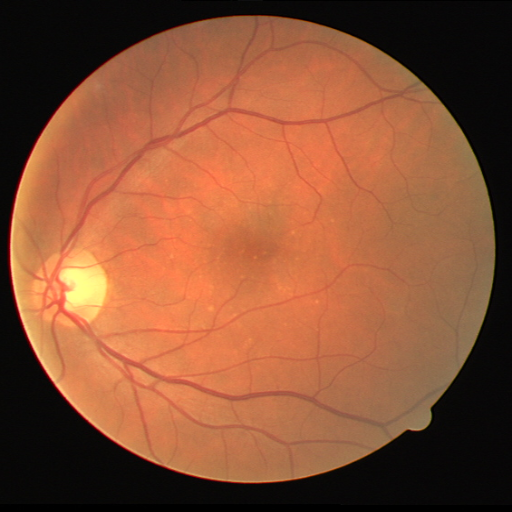

In [68]:
from PIL import Image

image = Image.open(r"/21_training_2.png")
image

In [84]:
image = cv2.imread('/21_training_2.png', cv2.IMREAD_COLOR)
image = image/255.0 ## (512, 512, 3)
image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
image = image.astype(np.float32)
image = torch.from_numpy(image)


In [86]:
image.size()

torch.Size([3, 512, 512])

In [75]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.PILToTensor()
])
  

img_tensor = transform(image)
img_tensor.size()

torch.Size([3, 512, 512])

In [87]:
x = torch.unsqueeze(image, dim=0)
x


tensor([[[[0.0275, 0.0235, 0.0275,  ..., 0.0000, 0.0039, 0.0039],
          [0.0314, 0.0314, 0.0275,  ..., 0.0275, 0.0275, 0.0235],
          [0.0353, 0.0314, 0.0235,  ..., 0.0235, 0.0235, 0.0196],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0275, 0.0235, 0.0235,  ..., 0.0000, 0.0039, 0.0039],
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0235],
          [0.0314, 0.0275, 0.0235,  ..., 0.0275, 0.0275, 0.0275],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0275, 0.0235, 0.0314,  ..., 0.0000, 0.0039, 0.0039],
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0235],
          [0.0314, 0.0275, 0.0235,  ..., 0

In [88]:
y=count(x)

torch.Size([1, 64, 254, 254])
torch.Size([1, 128, 125, 125])
torch.Size([1, 256, 60, 60])
torch.Size([1, 512, 28, 28])
torch.Size([1, 2, 324, 324])


In [93]:
import torchvision.transforms as T
transform = T. ToPILImage()
img = transform()

IndexError: ignored

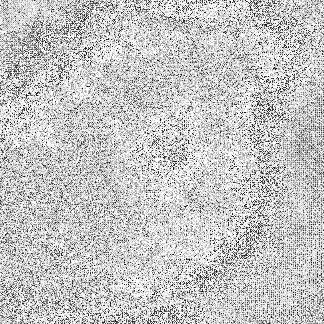

In [92]:
img

In [73]:
summary(count, (3, 512, 512))

torch.Size([2, 64, 254, 254])
torch.Size([2, 128, 125, 125])
torch.Size([2, 256, 60, 60])
torch.Size([2, 512, 28, 28])
torch.Size([2, 2, 324, 324])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 510, 510]           1,792
       BatchNorm2d-2         [-1, 64, 510, 510]             128
              ReLU-3         [-1, 64, 510, 510]               0
            Conv2d-4         [-1, 64, 508, 508]          36,928
       BatchNorm2d-5         [-1, 64, 508, 508]             128
              ReLU-6         [-1, 64, 508, 508]               0
       double_conv-7         [-1, 64, 508, 508]               0
         MaxPool2d-8         [-1, 64, 254, 254]               0
            Conv2d-9        [-1, 128, 252, 252]          73,856
      BatchNorm2d-10        [-1, 128, 252, 252]             256
             ReLU-11        [-1, 128, 252, 252]               0
           Conv2d-1

# data

In [5]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import zipfile
with zipfile.ZipFile('/content/archive (4).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data6')
class imgDataset(Dataset):
    def __init__(self, images_path, masks_path ):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)
        

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)
        


        return image, mask


    def __len__(self):
        return self.n_samples


# data augmentation

In [13]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate

""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))

    return (train_x, train_y), (test_x, test_y)

def augment_data(images, masks, save_path, augment=True):
    size = (512, 512)

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            

            

            X = [x, x1 ]
            Y = [y, y1 ]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

In [15]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate

""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))

    return (train_x, train_y), (test_x, test_y)

def augment_data(images, masks, save_path, augment=True):
    size = (512, 512)

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

         

           

            X = [x, x1]
            Y = [y, y1]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m,(324,324))

            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

In [16]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)

    """ Load the data """
    data_path = "/content/data6/DRIVE/"
    (train_x, train_y), (test_x, test_y) = load_data(data_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    """ Create directories to save the augmented data """
    create_dir("new_data11/train/image/")
    create_dir("new_data11/train/mask/")
    create_dir("new_data11/test/image/")
    create_dir("new_data11/test/mask/")

    """ Data augmentation """
    augment_data(train_x, train_y, "new_data11/train/", augment=True)
    augment_data(test_x, test_y, "new_data11/test/", augment=False)



Train: 3 - 3
Test: 1 - 1


100%|██████████| 1/1 [00:00<00:00, 24.60it/s]


# utils

In [9]:
import os
import time
import random
import numpy as np
import cv2
import torch

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True



""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# loss

In [10]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [11]:
import os
import time
from glob import glob

import torch
from torch.utils.data import DataLoader
import torch.nn as nn




def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward(retain_graph=True)
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [ ]:

seeding(42)
""" Directories """
create_dir("files")

""" Load dataset """
train_x = sorted(glob("/content/new_data11/train/image/*"))
train_y = sorted(glob("/content/new_data11/train/mask/*"))

valid_x = sorted(glob("/content/new_data11/test/image*"))
valid_y = sorted(glob("/content/new_data11/test/mask/*"))

data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

""" Hyperparameters """
H = 512
W = 512
size = (H, W)
batch_size = 2
num_epochs = 10
lr = 1e-4
checkpoint_path = "files/checkpoint.pth"

""" Dataset and loader """
train_dataset = imgDataset(train_x, train_y)
valid_dataset = imgDataset(valid_x, valid_y)

train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

device = torch.device('cpu')   
model = unet()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
##loss_fn = nn.BCEWithLogitsLoss()
loss_fn=DiceLoss()

""" Training the model """
best_valid_loss = float("inf")
for epoch in range(num_epochs):
  start_time = time.time()
  train_loss = train(model, train_loader, optimizer, loss_fn, device)
  valid_loss = evaluate(model, valid_loader, loss_fn, device)
  if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
  data_str += f'\tTrain Loss: {train_loss:.3f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
  print(data_str)
    

  

       
      

        

Dataset Size:
Train: 6 - Valid: 1

torch.Size([2, 64, 254, 254])
torch.Size([2, 128, 125, 125])
torch.Size([2, 256, 60, 60])
torch.Size([2, 512, 28, 28])
torch.Size([2, 1, 324, 324])
torch.Size([2, 64, 254, 254])
